<a href="https://colab.research.google.com/github/karsarobert/Machine_learning_2024/blob/main/CO_METEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import json
from datetime import datetime
from urllib.request import urlopen

# OpenWeather API kulcs
API_KEY = "f5e63d194c9d1447ab17da6eb27a14d8"

# Beolvasás és előkészítés
input_file = "CO_2024.csv"
output_file = "output_2024.csv"

df = pd.read_csv(input_file, delimiter=';')

# Függvény az EOV koordináták átváltásához
def convert_to_etrs(eov_easting, eov_northing):
    url = f'http://www.agt.bme.hu/on_line/etrs2eov/etrs2eov.php?e={eov_easting}&n={eov_northing}&sfradio=single&format=TXT'
    response = urlopen(url).read().decode('utf-8')
    converted_coords = response.split()[1:3]
    return float(converted_coords[0]), float(converted_coords[1])

# Függvény az OpenWeather API hívásához
def get_weather_data(lat, lon, start, end):
    base_url = "https://history.openweathermap.org/data/2.5/history/city"
    params = {
        "lat": lat,
        "lon": lon,
        "type": "hour",
        "start": start,
        #"end": start,
        "appid": API_KEY,
        "cnt": 1,
        "units": "metric"
    }
    response = requests.get(base_url, params=params)
    return response.json()

# Eredeti DataFrame kiegészítése OpenWeather adatokkal és átváltott koordinátákkal
for index, row in df.iterrows():
    eov_easting = row['EovX']
    eov_northing = row['EovY']

    # EOV koordináták átváltása ETRS89-re
    etrs_lon, etrs_lat = convert_to_etrs(eov_easting, eov_northing)

    start_timestamp = int(datetime.strptime(row['Jelzés dátuma'], "%Y.%m.%d %H:%M").timestamp())  #:%S
    end_timestamp = start_timestamp + 3600  # 1-hour interval

    weather_data = get_weather_data(etrs_lat, etrs_lon, start_timestamp, end_timestamp)

    # Kiegészítés az eredeti DataFrame-mel
    df.at[index, 'etrs_lat'] = etrs_lat
    df.at[index, 'etrs_lon'] = etrs_lon
    df.at[index, 'temperature'] = weather_data['list'][0]['main']['temp']
    df.at[index, 'feels_like'] = weather_data['list'][0]['main']['feels_like']
    df.at[index, 'pressure'] = weather_data['list'][0]['main']['pressure']
    df.at[index, 'humidity'] = weather_data['list'][0]['main']['humidity']
    df.at[index, 'temp_min'] = weather_data['list'][0]['main']['temp_min']
    df.at[index, 'temp_max'] = weather_data['list'][0]['main']['temp_max']
    df.at[index, 'wind_speed'] = weather_data['list'][0]['wind']['speed']
    df.at[index, 'deg'] = weather_data['list'][0]['wind']['deg']
    try: df.at[index, 'gust'] = weather_data['list'][0]['wind']['gust']
    except: df.at[index, 'gust'] = 0
    df.at[index, 'clouds'] = weather_data['list'][0]['clouds']['all']

# Kiegészített DataFrame mentése
df.to_csv(output_file, index=False)


In [ ]:
df.to_csv(output_file, index=False)

In [ ]:
weather_data['list'][0]

{'dt': 1708030800,
 'main': {'temp': 2.84,
  'feels_like': 2.84,
  'pressure': 1026,
  'humidity': 81,
  'temp_min': 2.84,
  'temp_max': 2.84},
 'wind': {'speed': 0.3, 'deg': 39, 'gust': 0.53},
 'clouds': {'all': 8},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01n'}]}

In [ ]:
weather_data['list'][0]['wind']

{'speed': 0.3, 'deg': 39, 'gust': 0.53}

In [ ]:
type(weather_data['list'][0]['wind']['gust'])

float

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import random

# Véletlenszerű időpont generálása
def generate_random_datetime(existing_dates):
    while True:
        random_date = datetime.now() - timedelta(days=random.randint(1, 182)) #364
        random_date = random_date.replace(hour=random.randint(0, 23), minute=random.randint(0, 59), second=random.randint(0, 59))

        # Ellenőrizzük, hogy a generált időpont még nem szerepel az existing_dates listában
        if random_date.strftime("%Y-%m-%d") not in existing_dates:
            return random_date

# Beolvasás és előkészítés
input_file = "CO_2024.csv"
output_file = "output_2024_full.csv"

# Előre beolvasott időpontok listája
df_existing = pd.read_csv(input_file, delimiter=';')
existing_dates = set(df_existing['Jelzés dátuma'].apply(lambda x: str(x).split()[0]))  # Csak a dátum rész szükséges

# Véletlenszerű időpontok generálása
num_generated_dates = 1000  # Módosíthatod az igényeid szerint
generated_dates = [generate_random_datetime(existing_dates) for _ in range(num_generated_dates)]

# DataFrame létrehozása a generált időpontokkal
df_generated = pd.DataFrame({'Jelzés dátuma': [date.strftime("%Y.%m.%d %H:%M") for date in generated_dates]})

# Eredeti DataFrame és generált DataFrame összefűzése
df_combined = pd.concat([df_existing, df_generated], ignore_index=True)

# Kombinált DataFrame mentése
df_combined.to_csv(output_file, index=False)


In [ ]:
df_generated.to_csv('No_CO.csv')

In [ ]:
import pandas as pd
import random

# CSV fájl beolvasása
csv_file_path = 'No_CO.csv'
df = pd.read_csv(csv_file_path)

# Magyarországi nagyvárosok és hozzájuk tartozó koordináták
nagyvarosok = {
    'Budapest': (47.4979, 19.0402),
    'Debrecen': (47.5316, 21.6273),
    'Szeged': (46.2530, 20.1414),
    'Miskolc': (48.1035, 20.7784),
    'Pecs': (46.0711, 18.2334),
    # ... további városok ...
}

# GPS koordináták generálása és hozzáadása a DataFrame-hez
latitude_list = []
longitude_list = []

for index, row in df.iterrows():
    city = random.choice(list(nagyvarosok.keys()))
    coord = nagyvarosok[city]

    latitude = random.uniform(coord[0], coord[0])
    longitude = random.uniform(coord[1], coord[1])

    latitude_list.append(latitude)
    longitude_list.append(longitude)

df['Latitude'] = latitude_list
df['Longitude'] = longitude_list


# Eredmények kiírása
df.to_csv('No_CO2.csv')


In [ ]:
import pandas as pd
import requests
import json
from datetime import datetime
from urllib.request import urlopen

# OpenWeather API kulcs
API_KEY = "f5e63d194c9d1447ab17da6eb27a14d8"

# Beolvasás és előkészítés
input_file = "No_CO2.csv"
output_file = "output_2024_noCO.csv"

df = pd.read_csv(input_file, delimiter=',')


# Függvény az OpenWeather API hívásához
def get_weather_data(lat, lon, start, end):
    base_url = "https://history.openweathermap.org/data/2.5/history/city"
    params = {
        "lat": lat,
        "lon": lon,
        "type": "hour",
        "start": start,
        #"end": start,
        "appid": API_KEY,
        "cnt": 1,
        "units": "metric"
    }
    response = requests.get(base_url, params=params)
    return response.json()

# Eredeti DataFrame kiegészítése OpenWeather adatokkal és átváltott koordinátákkal
for index, row in df.iterrows():
    etrs_lat = row['Latitude']
    etrs_lon = row['Longitude']

    start_timestamp = int(datetime.strptime(row['Jelzés dátuma'], "%Y.%m.%d %H:%M").timestamp())
    end_timestamp = start_timestamp + 3600  # 1-hour interval

    weather_data = get_weather_data(etrs_lat, etrs_lon, start_timestamp, end_timestamp)

    # Kiegészítés az eredeti DataFrame-mel
    df.at[index, 'etrs_lat'] = etrs_lat
    df.at[index, 'etrs_lon'] = etrs_lon
    df.at[index, 'temperature'] = weather_data['list'][0]['main']['temp']
    df.at[index, 'feels_like'] = weather_data['list'][0]['main']['feels_like']
    df.at[index, 'pressure'] = weather_data['list'][0]['main']['pressure']
    df.at[index, 'humidity'] = weather_data['list'][0]['main']['humidity']
    df.at[index, 'temp_min'] = weather_data['list'][0]['main']['temp_min']
    df.at[index, 'temp_max'] = weather_data['list'][0]['main']['temp_max']
    df.at[index, 'wind_speed'] = weather_data['list'][0]['wind']['speed']
    df.at[index, 'deg'] = weather_data['list'][0]['wind']['deg']
    try: df.at[index, 'gust'] = weather_data['list'][0]['wind']['gust']
    except: df.at[index, 'gust'] = 0
    df.at[index, 'clouds'] = weather_data['list'][0]['clouds']['all']

# Kiegészített DataFrame mentése
df.to_csv(output_file, index=False)

In [ ]:
df.to_csv(output_file, index=False)

In [ ]:
df.to_csv(output_file, index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)


# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest osztályozó létrehozása és tanítása
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = rf_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Pontosság: 0.76
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82       913
           1       0.68      0.60      0.64       487

    accuracy                           0.76      1400
   macro avg       0.74      0.73      0.73      1400
weighted avg       0.76      0.76      0.76      1400



In [ ]:
df

,Jelzés dátuma,month,day,etrs_lat,etrs_lon,temperature,feels_like,pressure,humidity,temp_min,temp_max,wind_speed,deg,gust,clouds,CO
0,2024-01-16 22:48:36,NaN,NaN,47.4979,19.0402,-1.78,-1.78,1012.0,80.0,-3.43,-1.10,1.03,0.0,0.00,88.0,0
1,2024-01-16 13:22:58,NaN,NaN,46.0711,18.2334,-2.02,-2.02,1013.0,100.0,-2.02,-2.02,0.00,0.0,0.00,100.0,0
2,2024-01-10 17:42:36,NaN,NaN,46.2530,20.1414,-3.06,-3.06,1032.0,75.0,-3.06,-3.06,0.75,321.0,0.86,4.0,0
3,2024-01-13 01:04:27,NaN,NaN,47.5316,21.6273,-5.13,-10.68,1022.0,93.0,-5.13,-5.13,4.12,190.0,0.00,12.0,0
4,2023-06-07 13:09:09,NaN,NaN,47.4979,19.0402,23.50,23.60,1014.0,65.0,22.29,23.90,2.06,120.0,0.00,75.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4661,2024.03.27 07:03,NaN,NaN,47.4979,19.0402,11.12,9.98,997.0,65.0,11.02,11.29,6.69,140.0,0.00,100.0,0
4662,2024.01.27 04:11,NaN,NaN,47.4979,19.0402,5.42,0.35,1024.0,70.0,5.04,5.57,9.26,310.0,0.00,20.0,0
4663,2024.05.13 18:10,NaN,NaN,46.0711,18.2334,17.98,17.01,1015.0,45.0,17.98,17.98,1.54,50.0,0.00,0.0,0
4664,2024.01.16 18:22,NaN,NaN,46.2530,20.1414,-0.36,-3.73,1016.0,90.0,-0.36,-0.36,2.78,167.0,4.07,100.0,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)   # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting osztályozó létrehozása és tanítása
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = gb_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Pontosság: 0.77
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       617
           1       0.69      0.55      0.62       317

    accuracy                           0.77       934
   macro avg       0.74      0.71      0.72       934
weighted avg       0.76      0.77      0.76       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)   # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logisztikus regresszió modell létrehozása és tanítása
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = logreg_model.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Pontosság: 0.66
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.70      0.87      0.77       617
           1       0.51      0.27      0.35       317

    accuracy                           0.66       934
   macro avg       0.60      0.57      0.56       934
weighted avg       0.63      0.66      0.63       934



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pontosság: 0.75


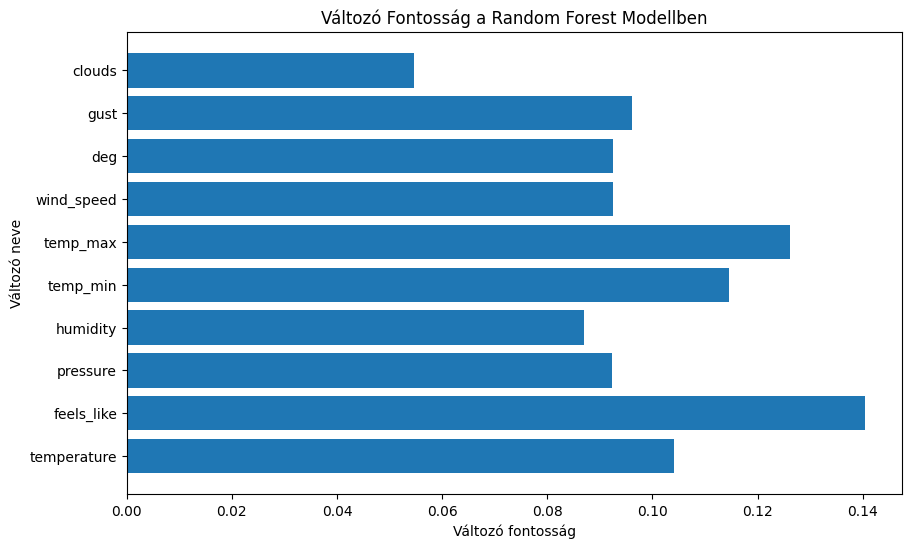

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest osztályozó létrehozása és tanítása
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = rf_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Változó fontosságának lekérdezése
feature_importances = rf_classifier.feature_importances_

# Bemeneti változók nevei
feature_names = X.columns

# Változó fontosságának megjelenítése diagramon
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Változó fontosság')
plt.ylabel('Változó neve')
plt.title('Változó Fontosság a Random Forest Modellben')
plt.show()


Mean Squared Error: 0.16


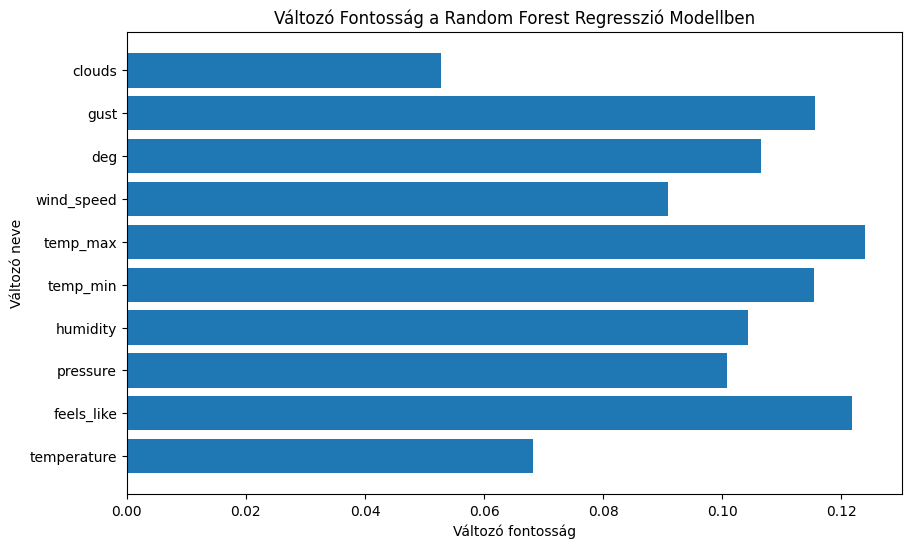

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és kimeneti változó kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a kimeneti változó

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest regresszor létrehozása és tanítása
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = rf_regressor.predict(X_test)

# Mean Squared Error kiszámolása
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Változó fontosságának lekérdezése
feature_importances = rf_regressor.feature_importances_

# Bemeneti változók nevei
feature_names = X.columns

# Változó fontosságának megjelenítése diagramon
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Változó fontosság')
plt.ylabel('Változó neve')
plt.title('Változó Fontosság a Random Forest Regresszió Modellben')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és kimeneti változó kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a kimeneti változó

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest regresszor létrehozása és tanítása
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = rf_regressor.predict(X_test)

# Táblázat létrehozása a regresszor által előrejelzett és a tényleges értékekről
results_table = pd.DataFrame({'Tényleges érték': y_test, 'Előrejelzett érték': y_pred})
print(results_table)


      Tényleges érték  Előrejelzett érték
3307                1                0.61
2699                1                0.56
3423                1                0.89
23                  0                0.06
1175                0                0.82
...               ...                 ...
2689                1                0.30
1149                0                0.49
1406                0                0.00
3337                1                0.68
2509                1                0.71

[934 rows x 2 columns]


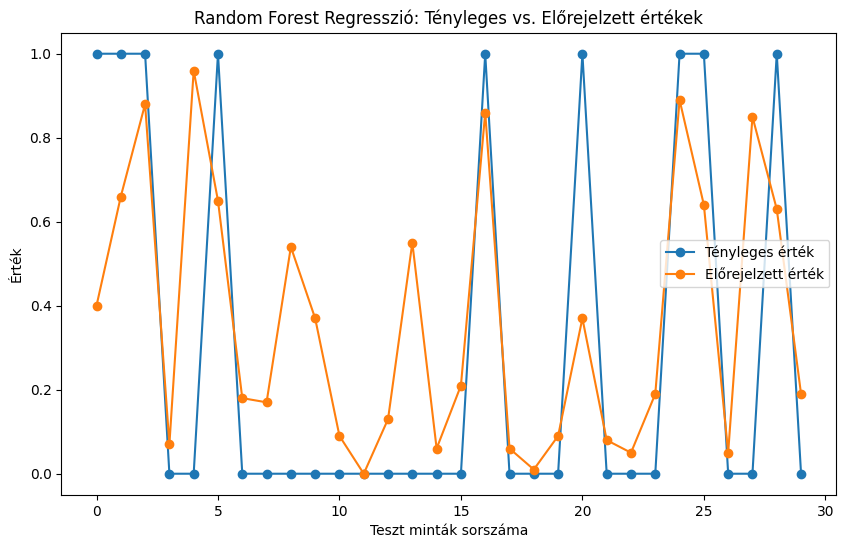

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és kimeneti változó kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a kimeneti változó

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Random Forest regresszor létrehozása és tanítása
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = rf_regressor.predict(X_test[:30])

# Grafikon készítése
plt.figure(figsize=(10, 6))
plt.plot(y_test[:30].values, label='Tényleges érték', marker='o')
plt.plot(y_pred, label='Előrejelzett érték', marker='o')
plt.xlabel('Teszt minták sorszáma')
plt.ylabel('Érték')
plt.title('Random Forest Regresszió: Tényleges vs. Előrejelzett értékek')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest osztályozó létrehozása
rf_classifier = RandomForestClassifier(random_state=42)

# Hiperparaméterek és azok érték-tartománya
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV létrehozása a legjobb paraméterek kiválasztásához
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Legjobb paraméterek lekérése
best_params = grid_search.best_params_
print('Legjobb paraméterek:', best_params)

# Legjobb becslő létrehozása a legjobb paraméterekkel
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = best_rf_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Legjobb paraméterek: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Pontosság: 0.76
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       617
           1       0.68      0.57      0.62       317

    accuracy                           0.76       934
   macro avg       0.74      0.72      0.72       934
weighted avg       0.76      0.76      0.76       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Adatok szintetikus bővítése a túlnyomórészt alulreprezentált osztályok számára
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Random Forest osztályozó létrehozása és tanítása a kiegyensúlyozott adatokon
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Teszt adatokon való értékelés
y_pred = rf_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Pontosság: 0.77
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       617
           1       0.66      0.64      0.65       317

    accuracy                           0.77       934
   macro avg       0.74      0.74      0.74       934
weighted avg       0.76      0.77      0.77       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok standardizálása
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Neurális hálózat létrehozása
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # 1 kimeneti neuron, mivel bináris osztályozás
])

# Modell összeállítása
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell tanítása
model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)

# Modell értékelése a teszt adatokon
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Pontosság: {accuracy:.2f}')

# Teszt adatokon való előrejelzés
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.3).astype(int)  # Környezeti küszöb beállítása (pl. 0.5)

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)



Epoch 1/50
120/120 [==============================] - 3s 9ms/step - loss: 0.6138 - accuracy: 0.6663 - val_loss: 0.7501 - val_accuracy: 0.5168
Epoch 2/50
120/120 [==============================] - 1s 6ms/step - loss: 0.5680 - accuracy: 0.6970 - val_loss: 0.8284 - val_accuracy: 0.4990
Epoch 3/50
120/120 [==============================] - 1s 8ms/step - loss: 0.5418 - accuracy: 0.7261 - val_loss: 0.7738 - val_accuracy: 0.5252
Epoch 4/50
120/120 [==============================] - 1s 9ms/step - loss: 0.5359 - accuracy: 0.7232 - val_loss: 0.8070 - val_accuracy: 0.5314
Epoch 5/50
120/120 [==============================] - 1s 10ms/step - loss: 0.5191 - accuracy: 0.7382 - val_loss: 0.7831 - val_accuracy: 0.5157
Epoch 6/50
120/120 [==============================] - 2s 14ms/step - loss: 0.5150 - accuracy: 0.7374 - val_loss: 0.7371 - val_accuracy: 0.5786
Epoch 7/50
120/120 [==============================] - 0s 4ms/step - loss: 0.5046 - accuracy: 0.7453 - val_loss: 0.5861 - val_accuracy: 0.6971
Epoc

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hiperparaméterek és azok érték-tartománya
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# XGBoost osztályozó létrehozása
xgb_classifier = XGBClassifier(random_state=42)

# GridSearchCV létrehozása a legjobb paraméterek kiválasztásához
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Legjobb paraméterek lekérése
best_params = grid_search.best_params_
print('Legjobb paraméterek:', best_params)

# Legjobb becslő létrehozása a legjobb paraméterekkel
best_xgb_classifier = XGBClassifier(**best_params, random_state=42)
best_xgb_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = best_xgb_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Legjobb paraméterek: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'subsample': 0.8}
Pontosság: 0.75
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       617
           1       0.65      0.58      0.61       317

    accuracy                           0.75       934
   macro avg       0.72      0.71      0.71       934
weighted avg       0.75      0.75      0.75       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma','month','day','CO', 'etrs_lat','etrs_lon'], axis=1)  # A 'CO' oszlop eltávolítása a bemeneti adatokból
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}

# XGBoost osztályozó létrehozása és tanítása
xgb_classifier = XGBClassifier(**param_grid, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Teszt adatokon való előrejelzés
y_pred_prob = xgb_classifier.predict_proba(X_test)[:, 1]  # Az osztály 1 valószínűsége

# Döntési küszöb beállítása
threshold = 0.2
y_pred = (y_pred_prob > threshold).astype(int)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)


Pontosság: 0.69
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.90      0.60      0.72       617
           1       0.53      0.87      0.66       317

    accuracy                           0.69       934
   macro avg       0.71      0.74      0.69       934
weighted avg       0.77      0.69      0.70       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma', 'month', 'day', 'CO', 'etrs_lat', 'etrs_lon'], axis=1)
y = df['CO']  # Az 'CO' oszlop a címkék


# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest osztályozó létrehozása
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)  # n_jobs=-1, hogy minden processzormagot használjunk

# Hiperparaméterek és azok érték-tartománya
param_grid = {
    'n_estimators': [100, 200],  # Kisebb számú érték a gyorsabb keresésért
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV létrehozása a legjobb paraméterek kiválasztásához
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Legjobb paraméterek lekérése
best_params = grid_search.best_params_
print('Legjobb paraméterek:', best_params)

# Legjobb becslő létrehozása a legjobb paraméterekkel
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = best_rf_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Legjobb paraméterek: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Pontosság: 0.79
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       601
           1       0.74      0.63      0.68       333

    accuracy                           0.79       934
   macro avg       0.78      0.76      0.76       934
weighted avg       0.79      0.79      0.79       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma', 'month', 'day', 'CO', 'etrs_lat', 'etrs_lon'], axis=1)
y = df['CO']  # Az 'CO' oszlop a címkék

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Random Forest osztályozó létrehozása
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Hiperparaméterek és azok érték-tartománya
param_grid = {
    'n_estimators': [100, 200],  # Kisebb számú érték a gyorsabb keresésért
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV létrehozása a legjobb paraméterek kiválasztásához
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='balanced_accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Legjobb paraméterek lekérése
best_params = grid_search.best_params_
print('Legjobb paraméterek:', best_params)

# Legjobb becslő létrehozása a legjobb paraméterekkel
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1, class_weight='balanced')
best_rf_classifier.fit(X_train, y_train)

# Teszt adatokon való értékelés
y_pred = best_rf_classifier.predict(X_test)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test, y_pred)
print('Osztályozás jelentés:\n', classification_rep)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Legjobb paraméterek: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Pontosság: 0.75
Osztályozás jelentés:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80       601
           1       0.64      0.68      0.66       333

    accuracy                           0.75       934
   macro avg       0.73      0.74      0.73       934
weighted avg       0.76      0.75      0.75       934



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma', 'month', 'day', 'CO', 'etrs_lat', 'etrs_lon'], axis=1)
y = df['CO']  # Az 'CO' oszlop a címkék

# Osztálycímkék átalakítása one-hot kódolássá
y_one_hot = to_categorical(y)

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

# Adatok szabványosítása
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neurális hálózat model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Model fordítása
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model betanítása
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Teszt adatokon való értékelés
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test_labels, y_pred)
print('Osztályozás jelentés:\n', classification_rep)

Epoch 1/50
94/94 - 5s - loss: 0.7024 - accuracy: 0.6027 - val_loss: 0.6199 - val_accuracy: 0.6546 - 5s/epoch - 55ms/step
Epoch 2/50
94/94 - 0s - loss: 0.6407 - accuracy: 0.6375 - val_loss: 0.6047 - val_accuracy: 0.6760 - 238ms/epoch - 3ms/step
Epoch 3/50
94/94 - 0s - loss: 0.6328 - accuracy: 0.6436 - val_loss: 0.5922 - val_accuracy: 0.6560 - 237ms/epoch - 3ms/step
Epoch 4/50
94/94 - 0s - loss: 0.6258 - accuracy: 0.6556 - val_loss: 0.5876 - val_accuracy: 0.6854 - 248ms/epoch - 3ms/step
Epoch 5/50
94/94 - 0s - loss: 0.6131 - accuracy: 0.6580 - val_loss: 0.5799 - val_accuracy: 0.6854 - 242ms/epoch - 3ms/step
Epoch 6/50
94/94 - 0s - loss: 0.6091 - accuracy: 0.6626 - val_loss: 0.5742 - val_accuracy: 0.6894 - 209ms/epoch - 2ms/step
Epoch 7/50
94/94 - 0s - loss: 0.5970 - accuracy: 0.6700 - val_loss: 0.5656 - val_accuracy: 0.6961 - 215ms/epoch - 2ms/step
Epoch 8/50
94/94 - 0s - loss: 0.6009 - accuracy: 0.6673 - val_loss: 0.5657 - val_accuracy: 0.6975 - 252ms/epoch - 3ms/step
Epoch 9/50
94/94 -

Epoch 1/300
47/47 - 1s - loss: 0.6980 - accuracy: 0.5956 - val_loss: 0.6154 - val_accuracy: 0.6586 - 1s/epoch - 30ms/step
Epoch 2/300
47/47 - 0s - loss: 0.6507 - accuracy: 0.6281 - val_loss: 0.5990 - val_accuracy: 0.6734 - 138ms/epoch - 3ms/step
Epoch 3/300
47/47 - 0s - loss: 0.6316 - accuracy: 0.6449 - val_loss: 0.5934 - val_accuracy: 0.6921 - 136ms/epoch - 3ms/step
Epoch 4/300
47/47 - 0s - loss: 0.6283 - accuracy: 0.6559 - val_loss: 0.5889 - val_accuracy: 0.6961 - 135ms/epoch - 3ms/step
Epoch 5/300
47/47 - 0s - loss: 0.6171 - accuracy: 0.6630 - val_loss: 0.5811 - val_accuracy: 0.6961 - 145ms/epoch - 3ms/step
Epoch 6/300
47/47 - 0s - loss: 0.6155 - accuracy: 0.6549 - val_loss: 0.5796 - val_accuracy: 0.6975 - 128ms/epoch - 3ms/step
Epoch 7/300
47/47 - 0s - loss: 0.6101 - accuracy: 0.6690 - val_loss: 0.5774 - val_accuracy: 0.6975 - 152ms/epoch - 3ms/step
Epoch 8/300
47/47 - 0s - loss: 0.6013 - accuracy: 0.6687 - val_loss: 0.5744 - val_accuracy: 0.6961 - 155ms/epoch - 3ms/step
Epoch 9/30

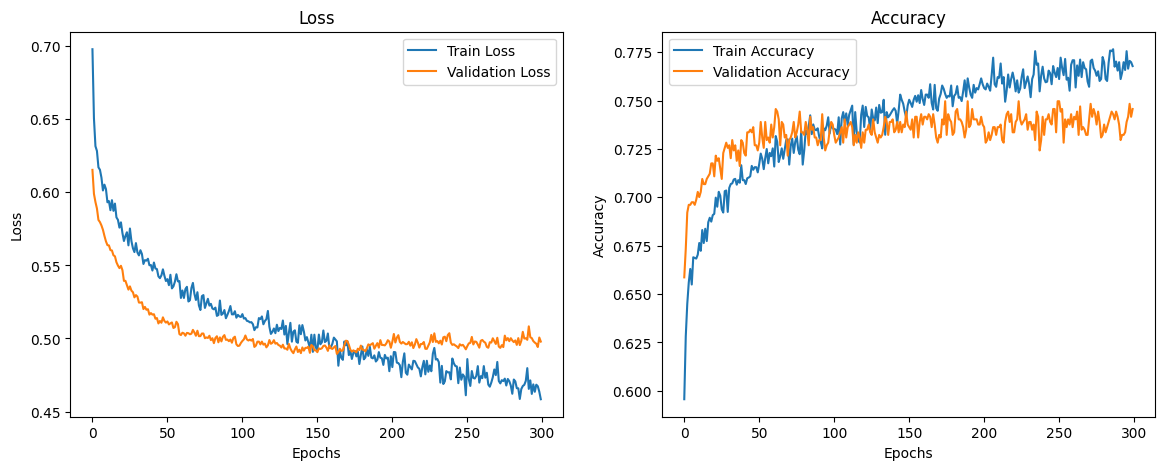

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma', 'month', 'day', 'CO', 'etrs_lat', 'etrs_lon'], axis=1)
y = df['CO']  # Az 'CO' oszlop a címkék

# Osztálycímkék átalakítása one-hot kódolássá
y_one_hot = to_categorical(y)

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

# Adatok szabványosítása
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neurális hálózat model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Model fordítása
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model betanítása
history = model.fit(X_train, y_train, epochs=300, batch_size=64, validation_split=0.2, verbose=2)

# Teszt adatokon való értékelés
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

# Pontosság kiértékelése
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test_labels, y_pred)
print('Osztályozás jelentés:\n', classification_rep)

# Loss és pontosság görbék kirajzolása
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss görbe
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Pontosság görbe
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Görbék kirajzolása
plt.show()

Epoch 1/200
94/94 - 5s - loss: 0.7277 - accuracy: 0.4905 - recall: 0.4905 - val_loss: 0.6834 - val_accuracy: 0.6091 - val_recall: 0.6091 - 5s/epoch - 58ms/step
Epoch 2/200
94/94 - 1s - loss: 0.6993 - accuracy: 0.5296 - recall: 0.5296 - val_loss: 0.6814 - val_accuracy: 0.6198 - val_recall: 0.6198 - 901ms/epoch - 10ms/step
Epoch 3/200
94/94 - 1s - loss: 0.6883 - accuracy: 0.5652 - recall: 0.5652 - val_loss: 0.6752 - val_accuracy: 0.6667 - val_recall: 0.6667 - 774ms/epoch - 8ms/step
Epoch 4/200
94/94 - 1s - loss: 0.6789 - accuracy: 0.5618 - recall: 0.5618 - val_loss: 0.6576 - val_accuracy: 0.6854 - val_recall: 0.6854 - 633ms/epoch - 7ms/step
Epoch 5/200
94/94 - 1s - loss: 0.6686 - accuracy: 0.5970 - recall: 0.5970 - val_loss: 0.6421 - val_accuracy: 0.6519 - val_recall: 0.6519 - 660ms/epoch - 7ms/step
Epoch 6/200
94/94 - 1s - loss: 0.6706 - accuracy: 0.5936 - recall: 0.5936 - val_loss: 0.6319 - val_accuracy: 0.6720 - val_recall: 0.6720 - 562ms/epoch - 6ms/step
Epoch 7/200
94/94 - 1s - loss

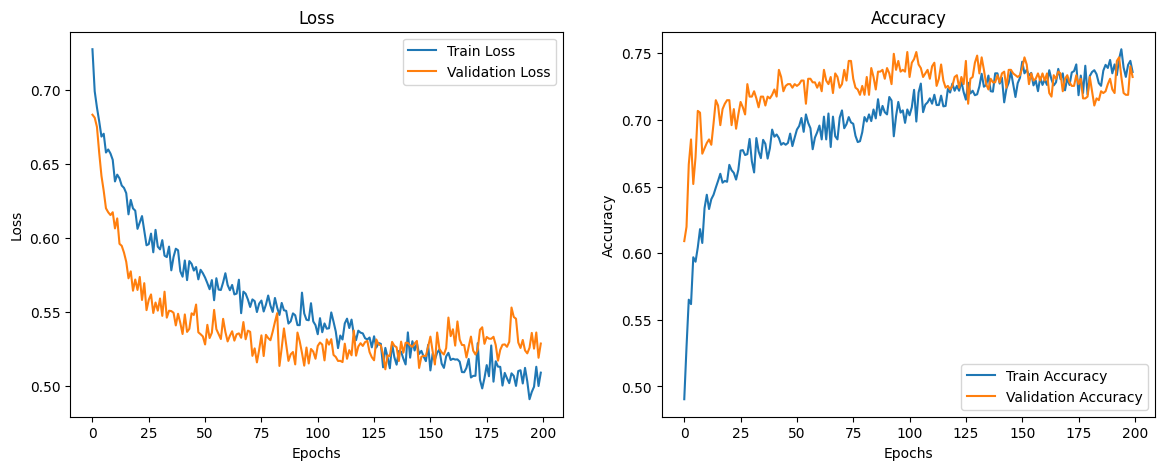

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# CSV fájl beolvasása
csv_file_path = 'CO_2023_2024_dataset.csv'  # A saját CSV fájlod elérési útja
df = pd.read_csv(csv_file_path)

# Bemeneti adatok és osztálycímkék kiválasztása
X = df.drop(['Jelzés dátuma', 'month', 'day', 'CO', 'etrs_lat', 'etrs_lon'], axis=1)
y = df['CO']  # Az 'CO' oszlop a címkék

# Osztálycímkék átalakítása one-hot kódolássá
y_one_hot = to_categorical(y)

# Adatok felosztása tanító és teszt adatokra
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

# Adatok szabványosítása
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Class weights kiszámítása
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

# Neurális hálózat model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))  # Neuronszám növelése a bemeneti rétegen
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Model fordítása
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

# Model betanítása
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=2, class_weight=class_weights)

# Teszt adatokon való értékelés
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=1)
y_test_labels = y_test.argmax(axis=1)

# Pontosság és visszahívás (recall) kiértékelése
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Pontosság: {accuracy:.2f}')

# Osztályozás jelentés kiírása
classification_rep = classification_report(y_test_labels, y_pred)
print('Osztályozás jelentés:\n', classification_rep)

# Loss és pontosság görbék kirajzolása
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss görbe
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Pontosság görbe
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Görbék kirajzolása
plt.show()